# Audio convolution

Processing anechoic speech by convolutions with RIRs to generate reverberrant speech examples, passing those speech examples through our featurization pipeline

In [1]:
import numpy as np
import librosa as lr
from librosa import display, feature
import pandas as pd
import soundfile as sf
import os
import matplotlib.pyplot as plt
import glob as glob
from tqdm import tqdm
from IPython.display import Audio
from scipy.signal import convolve
import pickle

In [2]:
speech_dir = "/scratch/ci411/sonos_rirs/voice_ace/Speech"

speech_files = np.sort(glob.glob(speech_dir+"/*.wav"))

target_rate = 16000

100%|██████████| 58/58 [00:52<00:00,  1.11it/s]


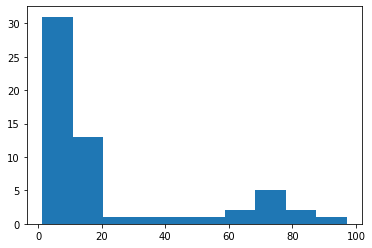

In [3]:
lengths = []
for file in tqdm(speech_files):
    y, sr = lr.load(file)
    lengths.append(len(y)/sr)
    
_=plt.hist(lengths, bins=10)

In [37]:
speech_df = pd.DataFrame(speech_files, columns=['file'])
speech_df['length (s)'] = lengths
speech_sample = speech_df.sample(10)
#speech_df.to_csv('./ace_speech.csv', index=False)

In [30]:
speech_df = pd.read_csv('./ace_speech.csv')
rir_df = pd.read_csv('/home/ci411/volume_estimation/0803_rir_df.csv')

In [45]:
n_rooms = rir_df.nunique(axis=0)['room']
n_samples = 2000
n_per_room = (n_samples//n_rooms) + 1
print(n_per_room)

28


<AxesSubplot:>

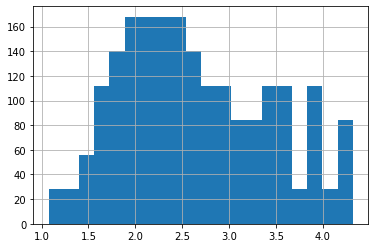

In [46]:
rir_sample = rir_df.groupby('room').sample(n=n_per_room, replace=True)
rir_sample['vol'].apply(np.log10).hist(bins=20)

In [38]:
rir, sr_rir = lr.load(rir_sample.iloc[9]['file'], sr=target_rate)
speech, sr_speech = lr.load(speech_sample.iloc[0]['file'], sr=target_rate)

In [39]:
#computer power of speech signal

def get_power(y):
    rms = lr.feature.rms(y=y)
    power = np.average(rms)**2
    return power

signal_power = get_power(speech)
print(signal_power)

noise = np.random.normal(size=len(speech))
noise_power = get_power(noise)
print(noise_power)

snr = 30 #in db
noise_ratio = signal_power / np.exp(snr/20)
print(noise_ratio)

noise_scaled = noise*np.sqrt(noise_ratio)
print(get_power(noise_scaled))

noisy_speech = speech + noise_scaled
Audio(data=noisy_speech, rate=target_rate)


0.0007591666554647748
0.9702334165729316
0.00016939297741320306
0.0001643507272190735


In [40]:
def conv_signals(speech, rir, snr=np.infty, noise=None):
    if noise == None:
        noise = np.random.normal(size=len(speech))
    noise_ratio = get_power(speech) / np.exp(snr/20)
    noise_scaled = noise * np.sqrt(noise_ratio)
    
    speech_signal = convolve(speech, rir, mode='same')
    noise_signal = convolve(noise_scaled, rir, mode='same')
    out_signal = speech_signal + noise_signal
    out_signal = out_signal / np.max(out_signal.flatten())
    return out_signal

def window_audio(speech, n_samples):
    offset_max = len(speech) - (n_samples+1)
    offset = np.random.randint(0, offset_max)
    return speech[offset:offset+n_samples]

In [44]:
sr = 22050
def generate_rir_audio(n_samples, speech_df, rir_sample, len_clip=4, sr=22050, return_audio=True,\
                       snr_list=[np.infty], verbose=False, out_path=None):
    #len_clip - length of clip in seconds
    valid_speech = speech_df[speech_df['length (s)']>=len_clip]
    speech_sample = valid_speech.sample(n_samples, replace=True).reset_index()
        
    sample_df = speech_sample.join(rir_sample, lsuffix='_speech', rsuffix='_rir')
    audio_clips = []
    
    output_df_list = []
    for row in tqdm(sample_df.iterrows()):
        speech, _ = lr.load(row[1]['file_speech'], sr=sr)
        rir, _ = lr.load(row[1]['file_rir'], sr=sr)
        windowed_speech = window_audio(speech, len_clip*sr)
        for snr in snr_list:
            out_row = row[1].copy()
            out_row['snr'] = snr
            conv_audio = conv_signals(windowed_speech, rir, snr=snr)
            if snr is np.infty:
                snr_tag = "snr_clean"
            else:
                snr_tag = "snr_{}db".format(snr)
            clipname = "clip{}_{}".format(row[0],snr_tag)
            out_row['clip_label'] = clipname
            if return_audio:
                audio_clips.append(conv_audio)
            if out_path is not None:
                file = os.path.join(out_path, '{}.wav'.format(clipname))
                out_row['file_clip'] = file
                sf.write(file, conv_audio, sr)
                if verbose:
                    print("Saved file to {}".format(file))
            output_df_list.append(out_row)
 
    out_df = pd.DataFrame(output_df_list).reset_index().drop(columns=['index'])
    df_path = os.path.join(out_path,'audio_df.csv')
    out_df.to_csv(df_path, index=False)
    print("Results stored to {}".format(df_path))
    if return_audio:
        return out_df, audio_clips
    else:
        return out_df

    

    
sample_df, audio_clips = generate_rir_audio(10, speech_df, rir_df, sr=sr, snr_list=[np.infty, 20, 10, 0],\
                                            verbose=False, out_path='/scratch/ci411/sonos_rirs/reverb_audio/testrun')
    

10it [00:13,  1.40s/it]

Results stored to /scratch/ci411/sonos_rirs/reverb_audio/testrun/audio_df.csv


In [ ]:
AUDIO_PATH = '/scratch/ci411/sonos_rirs/reverb_audio'
audioset_name = '080322_10K'

generate_rir_audio(n_samples, speech_df, rir_sample, sr=sr, snr_list=[np.infty, 20, 10, 0],\
                                            verbose=False, out_path='/scratch/ci411/sonos_rirs/reverb_audio/testrun')
    
    

In [ ]:
sample_df

In [43]:
Audio(filename='/scratch/ci411/sonos_rirs/reverb_audio/testrun/clip5_snr_clean.wav')

In [32]:
Audio(filename='/scratch/ci411/sonos_rirs/reverb_audio/testrun/clip5_snr_20db.wav')

In [33]:
Audio(filename='/scratch/ci411/sonos_rirs/reverb_audio/testrun/clip5_snr_10db.wav')

In [34]:
Audio(filename='/scratch/ci411/sonos_rirs/reverb_audio/testrun/clip5_snr_0db.wav')

In [44]:
import featurization_funcs as feat

In [45]:
path_audio = '/scratch/ci411/sonos_rirs/reverb_audio/testrun/clip0_snr_clean.wav'
y, sr= lr.load(path_audio, sr=sr)
n_samples = len(y)

In [46]:
gt_f = feat.gammatone_feat(n_samples)
dft_f = feat.dft_feat(n_samples, out_len=gt_f.out_shape[1])
dfts_f = feat.dft_feat(n_samples, is_sorted=True, out_len=gt_f.out_shape[1])
cepstrum_f = feat.cepstrum_feat(n_samples, out_len=gt_f.out_shape[1]) 
rms_f = feat.envelope_feat(n_samples, out_len=gt_f.out_shape[1])

feats = [gt_f, dft_f, dfts_f, cepstrum_f, rms_f]
block_f = feat.featurizer_block(n_samples, featurizations=feats, out_len=gt_f.out_shape[1])

Gammatone output shape: (20, 2755)
Dft output shape: (1, 2755)
Dft output shape: (1, 2755)
Ceptrum output shape: (1, 2755)
Envelope output shape: (1, 2755)
Featurization block output shape: (24, 2755)


/home/ci411/volume_estimation/featurization_funcs.py:159: RuntimeWarning: divide by zero encountered in log
  log_spec_amp = np.log(np.power(np.abs(dft),2))
/home/ci411/volume_estimation/featurization_funcs.py:56: RuntimeWarning: invalid value encountered in true_divide
  feature = feature/max(feature.flatten())


(24, 2755)


/scratch/ci411/.conda/envs/s3d_env/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


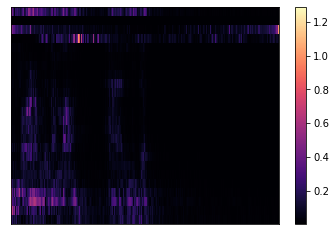

In [47]:
test_feat = block_f.process(y)
lr.display.specshow(test_feat)
print(test_feat.shape)
plt.colorbar()

In [48]:
output_dir = '/scratch/ci411/sonos_rirs/features/testrun'

In [61]:
def process_features(pairs_df, featurizer, output_dir, sr=16000, verbose=False,\
                     return_features=False):
    features = []
    volumes = []
    
    featurizer_path = os.path.join(output_dir, 'featurizer.pickle')
    
    with open(featurizer_path, 'wb') as f:
        pickle.dump(featurizer, f)
        
    if verbose:
        print("Saved featurizer to {}".format(featurizer_path))
        
    feat_files = []    
    for row in tqdm(pairs_df.iterrows()):
        row_tup = row[1]
        label = row_tup['clip_label']
        audio, _ = lr.load(row_tup['file_clip'], sr=sr)
        feature = featurizer.process(audio)
        
        filename = os.path.join(output_dir, label + '.npz')
        np.savez(filename, feat=feature, vol=row_tup['vol'])
        feat_files.append(filename)
        if verbose:
            print("Saved feature to {}".format(filename))
        
        if return_features:
            features.append(feature)
            volumes.append(row_tup['vol'])
    pairs_df['file_feature'] = feat_files
    df_path = os.path.join(output_dir, 'feature_df.csv')
    pairs_df.to_csv(df_path, index=false)
    print("Saved to {}".format(df_path))
    if return_features:
        return pairs_df, zip(features, volumes)
    else:
        return pairs_df
        

In [63]:
feat_df = process_features(sample_df, block_f, output_dir, sr=sr)

40it [00:04,  8.36it/s]


In [64]:
feat_df

,file_speech,length (s),file_rir,room,dataset,vol,snr,clip_label,file_clip,file_feature
0,/scratch/ci411/sonos_rirs/voice_ace/Speech/M9s...,12.300771,/scratch/ci411/sonos_rirs/pra/0721_pra/0721_pr...,0721_pra_room6,0721_pra,151.082409,inf,clip0_snr_clean,/scratch/ci411/sonos_rirs/reverb_audio/testrun...,/scratch/ci411/sonos_rirs/features/testrun/cli...
1,/scratch/ci411/sonos_rirs/voice_ace/Speech/M9s...,12.300771,/scratch/ci411/sonos_rirs/pra/0721_pra/0721_pr...,0721_pra_room6,0721_pra,151.082409,20.0,clip0_snr_20db,/scratch/ci411/sonos_rirs/reverb_audio/testrun...,/scratch/ci411/sonos_rirs/features/testrun/cli...
2,/scratch/ci411/sonos_rirs/voice_ace/Speech/M9s...,12.300771,/scratch/ci411/sonos_rirs/pra/0721_pra/0721_pr...,0721_pra_room6,0721_pra,151.082409,10.0,clip0_snr_10db,/scratch/ci411/sonos_rirs/reverb_audio/testrun...,/scratch/ci411/sonos_rirs/features/testrun/cli...
3,/scratch/ci411/sonos_rirs/voice_ace/Speech/M9s...,12.300771,/scratch/ci411/sonos_rirs/pra/0721_pra/0721_pr...,0721_pra_room6,0721_pra,151.082409,0.0,clip0_snr_0db,/scratch/ci411/sonos_rirs/reverb_audio/testrun...,/scratch/ci411/sonos_rirs/features/testrun/cli...
4,/scratch/ci411/sonos_rirs/voice_ace/Speech/M8s...,4.549252,/scratch/ci411/sonos_rirs/air/wav/air_office_0...,air_office,air,92.800000,inf,clip1_snr_clean,/scratch/ci411/sonos_rirs/reverb_audio/testrun...,/scratch/ci411/sonos_rirs/features/testrun/cli...
5,/scratch/ci411/sonos_rirs/voice_ace/Speech/M8s...,4.549252,/scratch/ci411/sonos_rirs/air/wav/air_office_0...,air_office,air,92.800000,20.0,clip1_snr_20db,/scratch/ci411/sonos_rirs/reverb_audio/testrun...,/scratch/ci411/sonos_rirs/features/testrun/cli...
6,/scratch/ci411/sonos_rirs/voice_ace/Speech/M8s...,4.549252,/scratch/ci411/sonos_rirs/air/wav/air_office_0...,air_office,air,92.800000,10.0,clip1_snr_10db,/scratch/ci411/sonos_rirs/reverb_audio/testrun...,/scratch/ci411/sonos_rirs/features/testrun/cli...
7,/scratch/ci411/sonos_rirs/voice_ace/Speech/M8s...,4.549252,/scratch/ci411/sonos_rirs/air/wav/air_office_0...,air_office,air,92.800000,0.0,clip1_snr_0db,/scratch/ci411/sonos_rirs/reverb_audio/testrun...,/scratch/ci411/sonos_rirs/features/testrun/cli...
8,/scratch/ci411/sonos_rirs/voice_ace/Speech/F4s...,35.924853,/scratch/ci411/sonos_rirs/air/wav/air_office_1...,air_office,air,92.800000,inf,clip2_snr_clean,/scratch/ci411/sonos_rirs/reverb_audio/testrun...,/scratch/ci411/sonos_rirs/features/testrun/cli...
9,/scratch/ci411/sonos_rirs/voice_ace/Speech/F4s...,35.924853,/scratch/ci411/sonos_rirs/air/wav/air_office_1...,air_office,air,92.800000,20.0,clip2_snr_20db,/scratch/ci411/sonos_rirs/reverb_audio/testrun...,/scratch/ci411/sonos_rirs/features/testrun/cli...


In [51]:
testpath = '/scratch/ci411/sonos_rirs/features/testrun/clip5_snr_10db.npz'
testload = np.load(testpath)

In [52]:
print(testload['feat'], '\n', testload['vol'])

[[ 2.30503441e-03+0.j          3.18228375e-03+0.j
   1.40594951e-02+0.j         ...  4.21890246e-04+0.j
   3.05887946e-04+0.j          4.70773369e-04+0.j        ]
 [ 1.24430433e-03+0.j          1.31106365e-02+0.j
   3.21886584e-02+0.j         ...  8.03805974e-04+0.j
   1.16646213e-03+0.j          1.00977329e-03+0.j        ]
 [ 4.65136038e-03+0.j          2.11579061e-02+0.j
   2.76932359e-02+0.j         ...  3.65673417e-04+0.j
   4.41437328e-04+0.j          6.94307529e-04+0.j        ]
 ...
 [-1.10490060e+00+0.41002545j -1.07283819e+00-0.03967043j
  -1.06774652e+00-0.14458086j ...  9.51394796e-01+0.51099664j
   9.45184231e-01-0.23883389j  1.00000000e+00+0.j        ]
 [ 1.00000000e+00+0.j          1.34877758e-02+0.j
   7.55341630e-03+0.j         ...  3.67982243e-03+0.j
   7.55341630e-03+0.j          1.34877758e-02+0.j        ]
 [ 3.40665162e-01+0.j          3.95072281e-01+0.j
   4.06250834e-01+0.j         ...  3.18510877e-03+0.j
   3.33531341e-03+0.j          2.70329393e-03+0.j        ]] 

In [53]:
featurizer_path = '/scratch/ci411/sonos_rirs/features/testrun/featurizer.pickle'
with open(featurizer_path, 'rb') as f:
    featurizer_load = pickle.load(f)

In [54]:
test_feat = block_f.process(y)
load_feat = featurizer_load.process(y)

In [55]:
np.all(test_feat==load_feat)

True